<a href="https://colab.research.google.com/github/AmirMoazzami/207_final_project/blob/Soroush/zillow_final_project_207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W207 Final Project (Baseline): Zillow Prize: Zillow’s Home Value Prediction

### Gray Selby
### Amir Moazami
### Soroush Yazdani

In this competition, Zillow has requested participants to predict the log-error between their Zestimate and the actual sale price of homes, using all available features. The log error is calculated as the logarithm of the Zestimate divided by the logarithm of the SalePrice:

**logerror = log(Zestimate) - log(SalePrice)**

We have been provided with a comprehensive dataset containing real estate properties from three counties in California: Los Angeles, Orange, and Ventura, for the year 2016.

The training data consists of all property transactions that occurred before October 15, 2016, as well as some transactions that took place after that date.

The test data available in the public leaderboard includes the remaining transactions that occurred between October 15 and December 31, 2016.

The rest of the test data, which is used to calculate the private leaderboard scores, encompasses all the properties sold between October 15, 2017, and December 15, 2017. This particular period is referred to as the "sales tracking period," during which no submissions will be accepted.

Our objective is to make predictions for six specific time points across all properties: October 2016 (201610), November 2016 (201611), December 2016 (201612), October 2017 (201710), November 2017 (201711), and December 2017 (201712).

When a property is sold multiple times within a 31-day period, we will consider the first reasonable value as the ground truth. The notion of "reasonable" entails selecting the transaction with a value that appears more accurate if the data seems questionable.

To begin, we will import the necessary libraries and obtain the dataset from Kaggle.com. Subsequently, we will conduct exploratory data analysis (EDA) to enhance the cleanliness of the dataset. Finally, we will employ basic machine learning techniques to establish a baseline model.









In [265]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Datasets

In order to access data we put the data on the Google Drive:

In [266]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading in the training data from the drive:

In [267]:
# Import the data from Google Drive
train_df = pd.read_csv("/content/drive/MyDrive/W207_Zillow/zillow-prize-1/train_2016_v2.csv", parse_dates=["transactiondate"])
train_df.shape

(90275, 3)

In the next section, we will examine the dataset and perform data analysis to gain insights. Due to the large size of the data, it is necessary to conduct exploratory data analysis (EDA) in order to clean and preprocess it effectively.

## Properties 2016

In [268]:
# creating new column and call it transaction_month
train_df['transaction_month'] = train_df['transactiondate'].dt.month
color = sns.color_palette()
# counting values
cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [269]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()


1    90026
2      123
3        1
Name: parcelid, dtype: int64

In [270]:
prop_df = pd.read_csv("/content/drive/MyDrive/W207_Zillow/zillow-prize-1/properties_2016.csv")
prop_df.shape
prop_df.info()


<ipython-input-270-3f3392018c7e>:1: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  prop_df = pd.read_csv("/content/drive/MyDrive/W207_Zillow/zillow-prize-1/properties_2016.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 58 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   parcelid                      int64  
 1   airconditioningtypeid         float64
 2   architecturalstyletypeid      float64
 3   basementsqft                  float64
 4   bathroomcnt                   float64
 5   bedroomcnt                    float64
 6   buildingclasstypeid           float64
 7   buildingqualitytypeid         float64
 8   calculatedbathnbr             float64
 9   decktypeid                    float64
 10  finishedfloor1squarefeet      float64
 11  calculatedfinishedsquarefeet  float64
 12  finishedsquarefeet12          float64
 13  finishedsquarefeet13          float64
 14  finishedsquarefeet15          float64
 15  finishedsquarefeet50          float64
 16  finishedsquarefeet6           float64
 17  fips                          float64
 18  fireplacecnt          

Based on the information gathered, it appears that the notices we possess are associated with the state of California, specifically Los Angeles, Orange, and Ventura counties.

We currently have a total of 90,811 announcements in the training dataset, while the overall dataset comprises 2,985,217 announcements.

To proceed with our analysis, it is now appropriate to merge the two files, combining them into a single dataset. This consolidation will enable us to conduct more comprehensive and detailed analysis.

In [271]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.0,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,NaN,NaN,NaN,2.5,4.0,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


Now let's check how many missing values we have:

In [272]:
# checking and counting the missing values
pd.options.display.max_rows = 65

dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df
dtype_df.groupby("Column Type").aggregate('count').reset_index()
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,90232,0.999524
9,buildingclasstypeid,90259,0.999823
16,finishedsquarefeet13,90242,0.999634
44,storytypeid,90232,0.999524


## EDA and Correlation Analysis

After examining the relationship between the source variable and the independent variables, it appears that the overall correlation is generally low. This suggests that there is limited linear association between these variables.

Furthermore, it is worth noting that there are certain variables that exhibit no significant relationship with the source variable at all. This lack of correlation could be attributed to the possibility that these variables hold values that are irrelevant or have no direct influence on the source variable.

These observations highlight the importance of further exploring and analyzing the dataset to identify and understand the key factors that truly impact the source variable. By delving deeper into the data, we can uncover additional insights and potentially discover other variables that are more strongly associated with the source variable.

<ipython-input-273-805f1f0bde46>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  median_values = train_df.mean(axis=0)
<ipython-input-273-805f1f0bde46>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  median_values = train_df.mean(axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


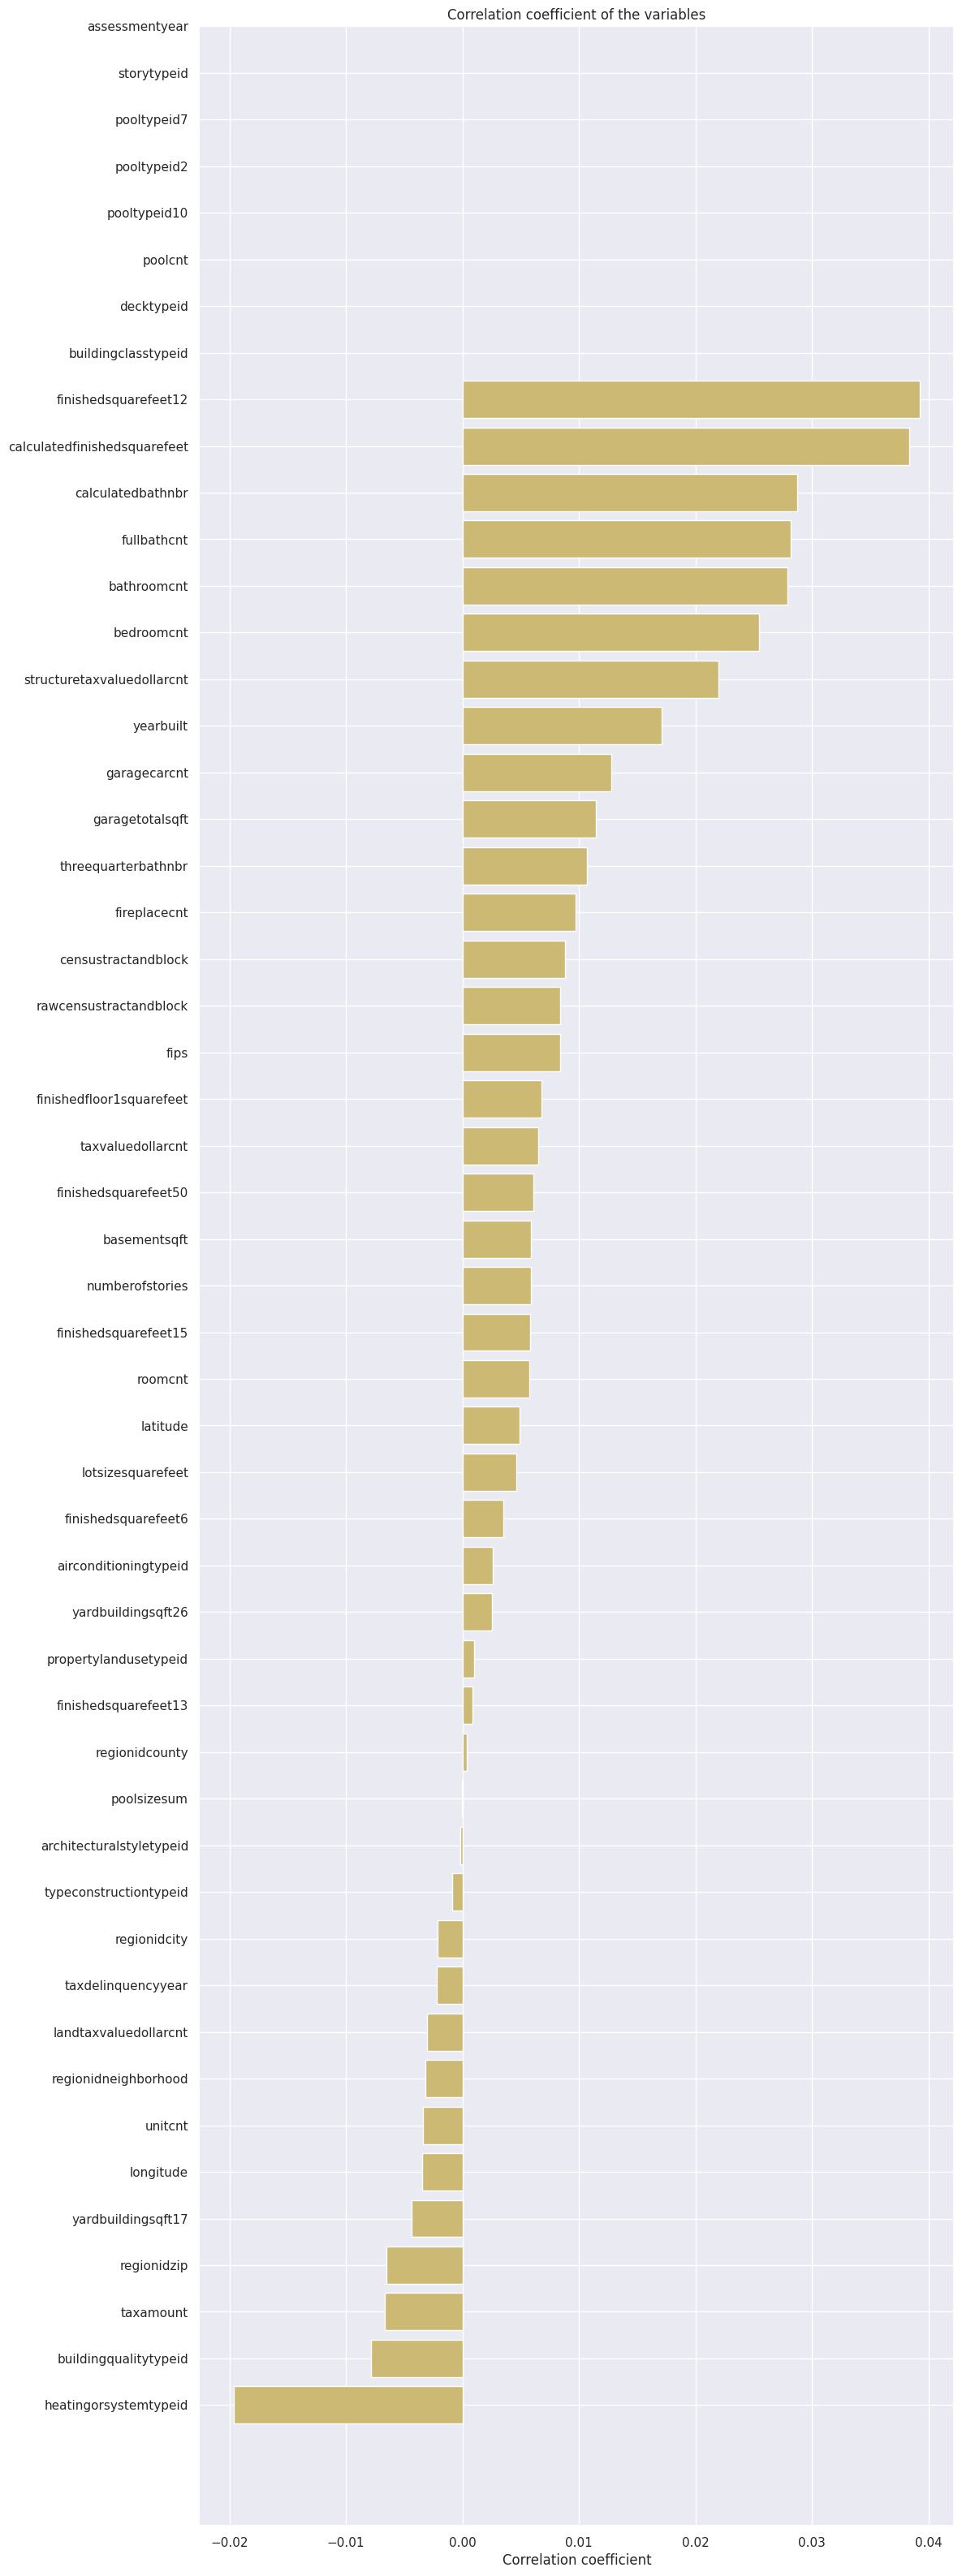

In [273]:
# Let us just impute the missing values with median values (instead of mean) to compute correlation coefficients #
#mean_values = train_df.mean(axis=0)
#train_df_new = train_df.fillna(mean_values, inplace=True)
median_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(median_values, inplace=True)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df.columns if col not in ['logerror'] if train_df[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df[col].values, train_df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

In [274]:
corr_zero_cols = ['assessmentyear', 'storytypeid', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid', 'buildingclasstypeid']
for col in corr_zero_cols:
    print(col, len(train_df[col].unique()))

assessmentyear 1
storytypeid 1
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1
buildingclasstypeid 1


Let's test the correlated values and remove the datas that have correlation between -0.01 and 0.02.

In [275]:
# removing correlation between -0.01 and 0.2
corr_df_sel = corr_df.loc[(corr_df['corr_values']>0.02) | (corr_df['corr_values'] < -0.01)]
corr_df_sel


,col_labels,corr_values
21,heatingorsystemtypeid,-0.019648
45,structuretaxvaluedollarcnt,0.021935
4,bedroomcnt,0.025467
3,bathroomcnt,0.027889
18,fullbathcnt,0.028169
7,calculatedbathnbr,0.028758
10,calculatedfinishedsquarefeet,0.038341
11,finishedsquarefeet12,0.039248


Now let's plotting the important variables correlation again. We want to make sure we pick the most relevant values.

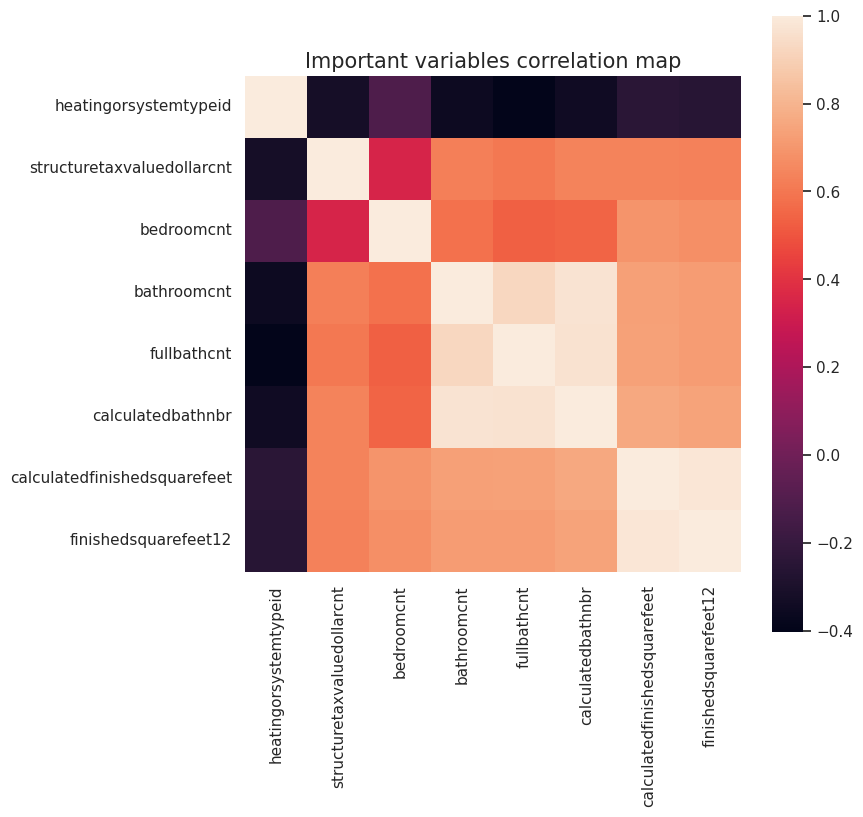

In [276]:
# Plotting the important variables correlation

cols_to_use = corr_df_sel.col_labels.tolist()

temp_df = train_df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()

In [277]:
# displaying the final train_df
display(train_df)

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.000000,7.229885,713.581395,2.0,3.0,4.0,...,1.440739,1.0,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,13.402692,6.037107e+13
1,14366692,-0.1684,2016-01-01,1,1.816372,7.229885,713.581395,3.5,4.0,4.0,...,1.440739,1.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,13.402692,6.049151e+13
2,12098116,-0.0040,2016-01-01,1,1.000000,7.229885,713.581395,3.0,2.0,4.0,...,1.440739,1.0,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,13.402692,6.037464e+13
3,12643413,0.0218,2016-01-02,1,1.000000,7.229885,713.581395,2.0,2.0,4.0,...,1.440739,1.0,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,13.402692,6.037296e+13
4,14432541,-0.0050,2016-01-02,1,1.816372,7.229885,713.581395,2.5,4.0,4.0,...,2.000000,1.0,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,13.402692,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.0356,2016-12-30,12,1.000000,7.229885,713.581395,1.0,1.0,4.0,...,1.440739,1.0,43800.0,191000.0,2015.0,147200.0,2495.24,NaN,13.402692,6.037132e+13
90271,12046695,0.0070,2016-12-30,12,1.816372,7.229885,713.581395,3.0,3.0,4.0,...,1.440739,1.0,117893.0,161111.0,2015.0,43218.0,1886.54,NaN,13.402692,6.037301e+13
90272,12995401,-0.2679,2016-12-30,12,1.816372,7.229885,713.581395,2.0,4.0,4.0,...,1.440739,1.0,22008.0,38096.0,2015.0,16088.0,1925.70,Y,14.000000,6.037433e+13
90273,11402105,0.0602,2016-12-30,12,1.816372,7.229885,713.581395,2.0,2.0,4.0,...,1.440739,1.0,132991.0,165869.0,2015.0,32878.0,2285.57,NaN,13.402692,6.037601e+13


## Feature Selection and Baseline Model

We used **ExtraTreesRegressor** library from Sklearn library here to find which features are the most important ones. Sklearn uses other libraries such as Random Forest, Gradient Boosting, AdaBoost regressor libraries to perform regression tasks. We will study those libraries in depth later.

Also, we are getting rid of the below features since they don't have good correlation with data:


* "hashottuborspa"
* "propertycountylandusecode"
* "propertyzoningdesc"
* "fireplaceflag"
* "taxdelinquencyflag"



In [278]:
# let's just make a copy of train_df so we have the original one
train_df_orig = train_df

In [279]:
# Let's get rid of some of useless columns :D
train_y = train_df_orig['logerror'].values
cat_cols = ["hashottuborspa", "propertycountylandusecode", "propertyzoningdesc", "fireplaceflag", "taxdelinquencyflag"]
train_df = train_df_orig.drop(['parcelid', 'logerror', 'transactiondate', 'transactiondate']+cat_cols, axis=1)
feat_names = train_df.columns.values

Now we are using ExtraTreesRegressor library to predict which features are the most important one:

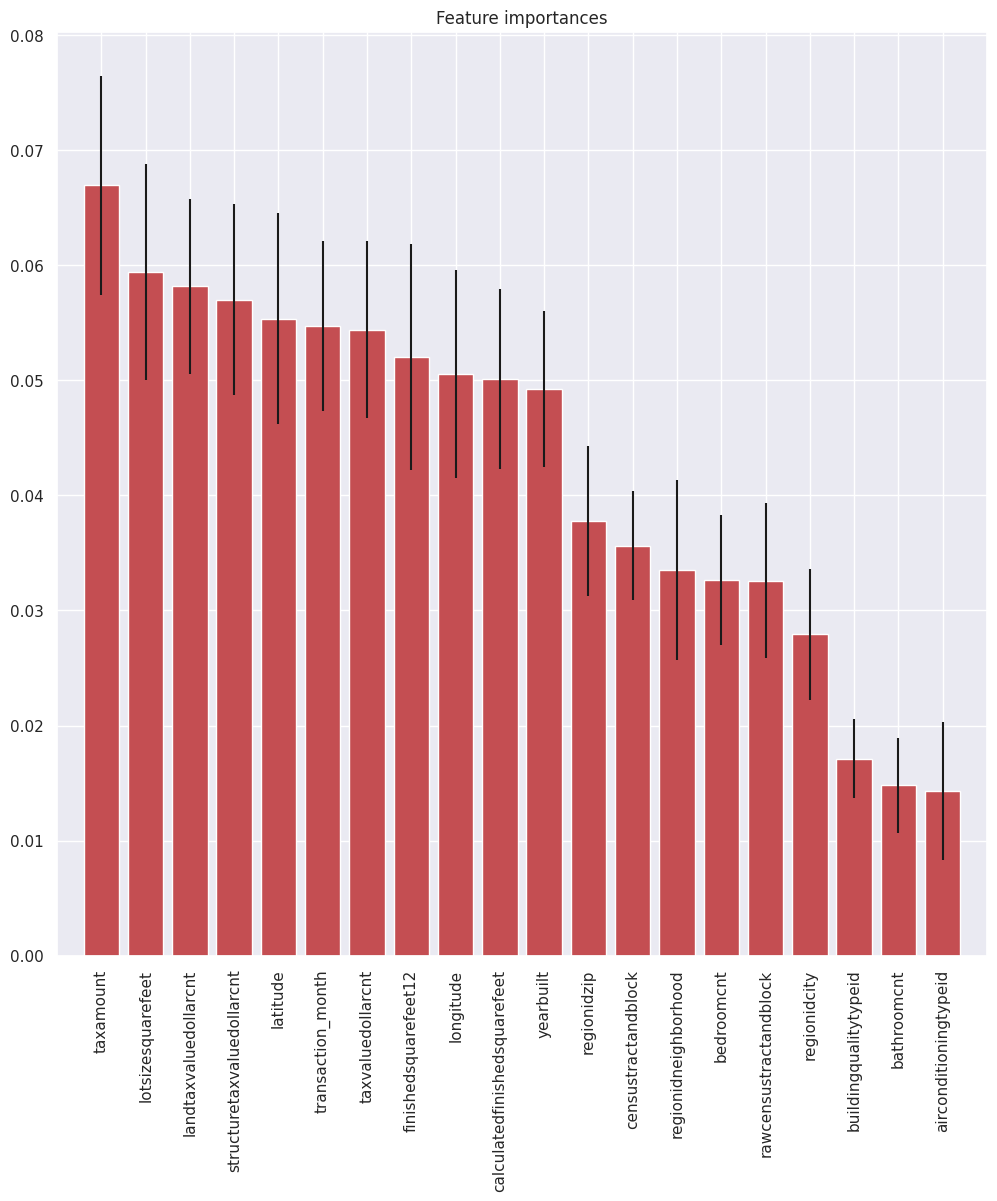

In [260]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=25, max_depth=30, max_features=0.3, n_jobs=-1, random_state=0)
model.fit(train_df, train_y)

## plot the importances ##
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()


Based on our analysis, it appears that the tax amount variable exhibits the strongest correlation with the source variable. Therefore, for our baseline model, we can argue that the tax amount could be our main feature which influence the price. This will serve as a starting point for our model, allowing us to assess its performance.

In the next section, we will dive deeper into feature selection and study the relationship between additional features and the source variable. By gradually incorporating more relevant features, we can enhance the robustness of our model.

### Building Some Models

To keep things simple, we will keep just a few columns. We use sklearn for now but later we can explore more:

Let's see how we can do the learning from Tensor Flow and from what we learned in the class:

In [284]:
# Building the model function
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # linear regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch
  # SGD. We can specify the batch size to use for training later.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, we compile the model. This finalizes the graph for training.
  # We specify the MSE loss.
  model.compile(loss='mse', optimizer=optimizer)
  return model

With try and error it turned out the we need to use very small learning rate steps. We used 1e-8 as our learning rate.

In [282]:
# We have to use a very small learning rate
model = build_model(num_features=1, learning_rate=1e-8)

history = model.fit(
  x = train_df[['taxamount']],
  y = train_y,
  validation_split=0.1,  # use 10% of the examples as a validation set
  epochs=10,
  batch_size=32,
  verbose=0)

# Convert the return value into a DataFrame so we can see the loss after each
# epoch. The history includes training data loss ('loss') and validation data
# loss ('val_loss').
history = pd.DataFrame(history.history)
display(history)

,loss,val_loss
0,285058.750000,1.216372
1,4034.241455,10.403210
2,80.978249,194.268341
3,71.166725,1.017658
4,10.131118,0.641021
5,8.388845,0.914356
6,10.596231,3.339621
7,30.971771,1.111116
8,22.605045,0.686271
9,35.602695,0.975944


Now let's plot our loss to see how we are doing:

In [283]:
def plot_loss(model, history):
  """Plot the loss after each training epoch."""
  # Convert the history object into a DataFrame.
  history = pd.DataFrame(history.history)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(range(len(history)), history['loss'], marker='.', color='black')
  plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  # Show the final train loss value and the learned model weights.
  print('Final train loss:', list(history['loss'])[-1])
  print('Final weights:', model.layers[0].get_weights())

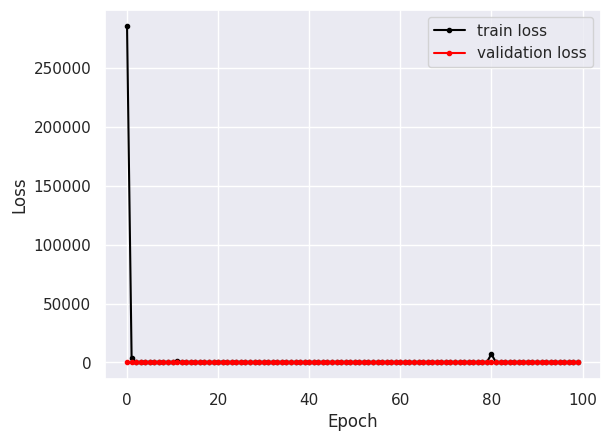

Final train loss: 57.84098434448242
Final weights: [array([[-5.2353418e-05]], dtype=float32), array([0.99913764], dtype=float32)]


In [289]:
# looping through the list and plot them
rates = [1e-8]
for i in range(len(rates)):
  model = build_model(num_features=1, learning_rate=rates[i])
  history = model.fit(
    # use the normalized features prepared above
    x = train_df[['taxamount']],
    y = train_y,
    validation_split=0.1,  # use 10% of the examples as a validation set
    epochs=100,
    batch_size=32,
    verbose=0)
  # plotting
  plot_loss(model, history)

Well, not bad! Our loss after 100 iteration is around 58. but this took a very long time to converge. We might need to bring down the epochs cycle. Also, we need to add more features to the model later. But for Baseline this is a good start.

In next step let's try something new. We used **Lasso** model from Sklearn library. In scikit-learn, the Lasso model refers to the Lasso regression algorithm, which is a linear regression model that incorporates L1 regularization.

Lasso regression is a type of linear regression that performs both variable selection and regularization by adding a penalty term to the ordinary least squares (OLS) objective function.

We picked this model based on the suggestion that we found on the Kaggle notebooks. We will dive more into this model and other Sklearn models in our final project.

In [176]:
# importing sklearn libraries
from sklearn.preprocessing import StandardScaler , RobustScaler
from sklearn.model_selection import train_test_split , cross_val_predict , RandomizedSearchCV
from sklearn.linear_model import Ridge , Lasso , ElasticNet
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor , ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn import linear_model

In [177]:
# Using sklearn to split the train and test data
train_df , x_validation , train_y , y_validation = train_test_split(train_df , train_y , test_size=0.15 , shuffle=True , random_state=55)

In [294]:
# Defining the model function so later we try different models easily.
lis_model_score = []

def modeling(model) :
    pipe = Pipeline([
        ('scaling' , StandardScaler()) ,
        ('model' , model)
    ])

    prediction = cross_val_predict(pipe , train_df , train_y , cv=5)
    lis_model_score.append([
        model ,
        r2_score(prediction , train_y).round(4) ,
        mean_absolute_error(prediction , train_y).round(2) ,
        np.sqrt(mean_squared_error(prediction , train_y)).round(2)
    ])

In [295]:
algorithms =  [Lasso()]
for model in algorithms :
    modeling(model)
result = pd.DataFrame(lis_model_score , columns=['Model' , 'R2 score' , 'MAE score' , 'RMSE score']).sort_values('MAE score')
result.head(2)

,Model,R2 score,MAE score,RMSE score
0,Lasso(),-29970.6143,0.07,0.16


### Next Steps


For now we tried TensorFlow and Lasso model from sklearn. For final project, we are planning to add more features and models to beat our baseline model.

To be continued....!